## X-SAPR CMAC 2.0

Test for second trip rejection and using texture filter and gate ids to
analysis.

In [1]:
import cartopy
import imp
import matplotlib
import matplotlib.patheffects as mpatheffects
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import operator
import os
import pandas as pd
import pyart
import tempfile
import yt

from boto.s3.connection import S3Connection
from datetime import datetime

import processing_code

%matplotlib inline
get_ipython().magic(
    'install_ext https://raw.github.com/cpcloud/ipython-\
autotime/master/autotime.py')
get_ipython().magic('load_ext autotime')

ModuleNotFoundError: No module named 'cartopy'

In [2]:
# Helper function for the search.
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.

    Parameters
    ----------
    site : string
        four letter radar designation.
    datetime_t : datetime
        desired date time.

    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime.

    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket.
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files.
    bucket_list = list(bucket.list(prefix = my_pref))

    # We are going to create a list of keys and datetimes to allow easy searching.
    keys = []
    datetimes = []

    # Populate the list.
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    #find the closest available radar to your datetime

    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

time: 68.6 ms


In [3]:
radar = pyart.io.read('/home/zsherman/xsapr_sgp/data/05_19_2017/XSW170519014005.RAW54Y8')
radar.altitude['data'][0] = 320.0

time: 693 ms


In [4]:
radar.altitude

{'data': array([ 320.]),
 'long_name': 'Altitude',
 'positive': 'up',
 'standard_name': 'Altitude',
 'units': 'meters'}

time: 5.78 ms


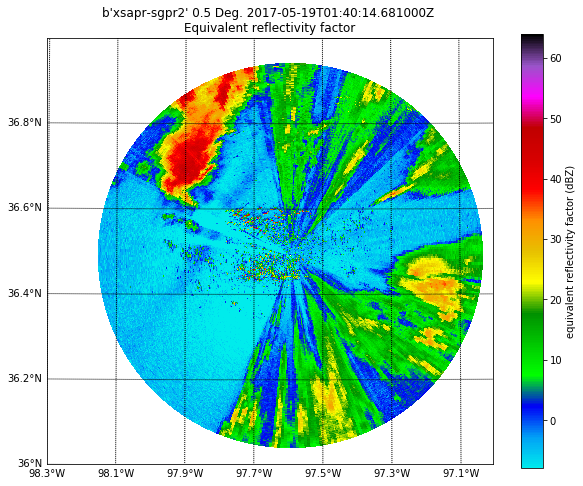

time: 937 ms


In [5]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('reflectivity', sweep=0, resolution='c',
                     vmin=-8, vmax=64, mask_outside=False,
                     cmap=pyart.graph.cm.NWSRef,
                     min_lat=min_lat, min_lon=min_lon,
                     max_lat=max_lat, max_lon=max_lon,
                     lat_lines=lal, lon_lines=lol)
# plt.savefig('')

In [6]:
time_at_start_of_radar = netCDF4.num2date(radar.time['data'][0], 
                                          radar.time['units'])
my_radar = get_radar_from_aws('KVNX', time_at_start_of_radar )

ERROR:boto:Caught exception reading instance data
Traceback (most recent call last):
  File "/home/zsherman/anaconda3/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/home/zsherman/anaconda3/lib/python3.5/http/client.py", line 1107, in request
    self._send_request(method, url, body, headers)
  File "/home/zsherman/anaconda3/lib/python3.5/http/client.py", line 1152, in _send_request
    self.endheaders(body)
  File "/home/zsherman/anaconda3/lib/python3.5/http/client.py", line 1103, in endheaders
    self._send_output(message_body)
  File "/home/zsherman/anaconda3/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/home/zsherman/anaconda3/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/home/zsherman/anaconda3/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/home/zsherman/a

time: 5.73 s


In [7]:
my_radar.fields.keys()

dict_keys(['cross_correlation_ratio', 'spectrum_width', 'reflectivity', 'differential_phase', 'velocity', 'differential_reflectivity'])

time: 2.76 ms


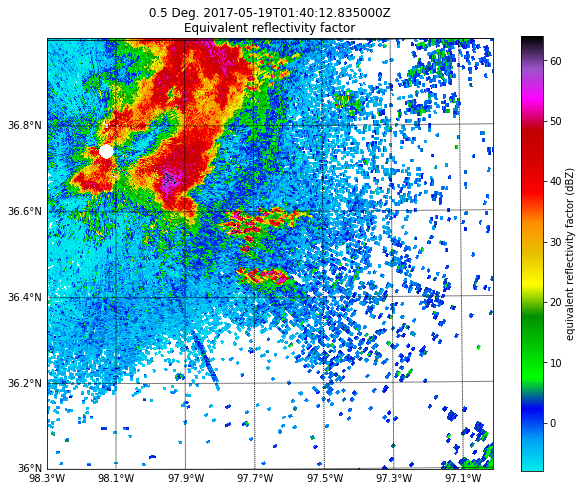

time: 1.71 s


In [8]:
display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('reflectivity', sweep=0, resolution='c',
                     vmin=-8, vmax=64, mask_outside=False,
                     cmap=pyart.graph.cm.NWSRef,
                     min_lat=min_lat, min_lon=min_lon,
                     max_lat=max_lat, max_lon=max_lon,
                     lat_lines=lal, lon_lines=lol)
# plt.savefig('')

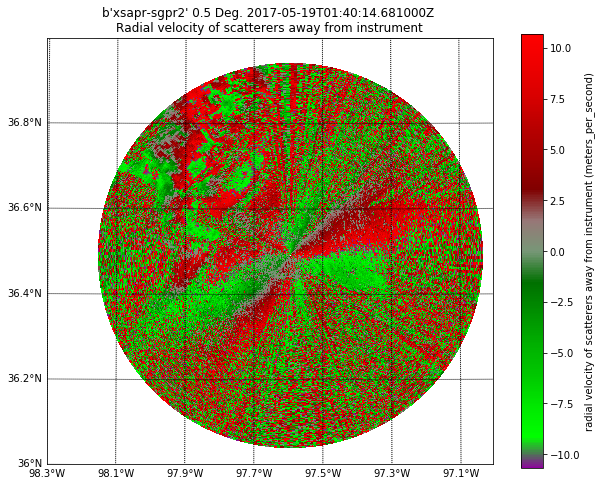

time: 988 ms


In [9]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)
nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('velocity', sweep=0, resolution='c',
                    vmin=-nyq, vmax=nyq, mask_outside=False,
                    cmap=pyart.graph.cm.NWSVel,
                    min_lat=min_lat, min_lon=min_lon,
                    max_lat=max_lat, max_lon=max_lon,
                    lat_lines=lal, lon_lines=lol)
# plt.savefig('')

In [10]:
print(radar.fixed_angle['data'])

[  0.49987793   1.49963379   2.49938965   3.49914551   4.49890137
   5.49865723   6.49841309   7.49816895   8.4979248    9.49768066
  10.49743652  11.50268555  12.50244141  14.0020752   15.00183105
  17.00134277  20.00061035  24.99938965  29.99816895  40.0012207
  49.9987793   54.99755859  60.00183105]
time: 2.7 ms


In [11]:
radar_start_date = netCDF4.num2date(
    radar.time['data'][0], radar.time['units'])
print(radar_start_date)
ymd_string = datetime.strftime(radar_start_date, '%Y%m%d')
hms_string = datetime.strftime(radar_start_date, '%H%M%S')
print(ymd_string, hms_string)

2017-05-19 01:40:14.681000
20170519 014014
time: 6.63 ms


In [12]:
sndfile = '/home/zsherman/xsapr_sgp/data/sonde_05_2017/sgpsondewnpnC1.b1.20170517.052500.cdf'
# soundings_dir = '/home/zsherman/xsapr_sgp/data/sonde_05_2017/'
# z_dict, temp_dict, snr = processing_code.snr_and_sounding(
    # radar, soundings_dir, override_file=sndfile)
sonde = netCDF4.Dataset(sndfile)
print(sonde.variables.keys())

odict_keys(['base_time', 'time_offset', 'time', 'qc_time', 'pres', 'qc_pres', 'tdry', 'qc_tdry', 'dp', 'qc_dp', 'wspd', 'qc_wspd', 'deg', 'qc_deg', 'rh', 'qc_rh', 'u_wind', 'qc_u_wind', 'v_wind', 'qc_v_wind', 'wstat', 'asc', 'qc_asc', 'lat', 'lon', 'alt'])
time: 5.18 ms


In [13]:
radar.instrument_parameters['nyquist_velocity']['data']

array([ 10.69499969,  10.69499969,  10.69499969, ...,  10.69499969,
        10.69499969,  10.69499969], dtype=float32)

time: 1.85 ms


In [14]:
z_dict, temp_dict = pyart.retrieve.map_profile_to_gates(
    sonde.variables['tdry'][:], sonde.variables['alt'][:], radar)
texture = processing_code.get_texture(radar)

1.5949304103851318
time: 2.26 s


In [15]:
snr = pyart.retrieve.calculate_snr_from_reflectivity(radar)

time: 625 ms


In [16]:
radar.add_field('sounding_temperature', temp_dict, replace_existing=True)
radar.add_field('height', z_dict, replace_existing=True)
radar.add_field('SNR', snr, replace_existing=True)
radar.add_field('velocity_texture', texture, replace_existing=True)
print(radar.fields.keys())

dict_keys(['velocity_texture', 'normalized_coherent_power', 'spectrum_width', 'reflectivity', 'specific_differential_phase', 'differential_reflectivity', 'SNR', 'total_power', 'height', 'cross_correlation_ratio', 'sounding_temperature', 'velocity', 'differential_phase'])
time: 3.57 ms


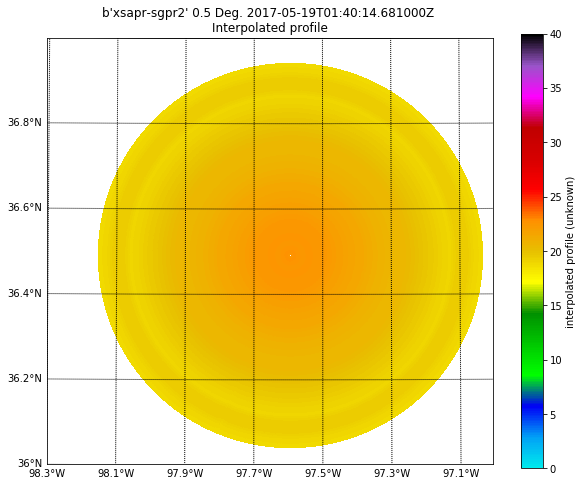

time: 782 ms


In [17]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('sounding_temperature', sweep=0, resolution='c',
                     vmin=-0, vmax=40, mask_outside=False,
                     cmap=pyart.graph.cm.NWSRef,
                     min_lat=min_lat, min_lon=min_lon,
                     max_lat=max_lat, max_lon=max_lon,
                     lat_lines=lal, lon_lines=lol)
# plt.savefig('')

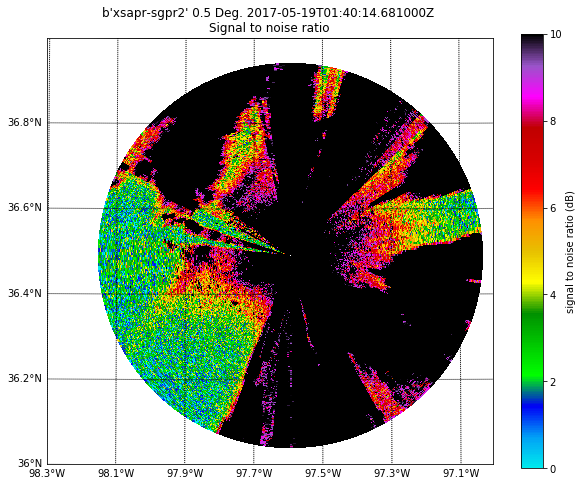

time: 795 ms


In [18]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('SNR', sweep=0, resolution='c',
                     vmin=0, vmax=10, mask_outside=False,
                     cmap=pyart.graph.cm.NWSRef,
                     min_lat=min_lat, min_lon=min_lon,
                     max_lat=max_lat, max_lon=max_lon,
                     lat_lines=lal, lon_lines=lol)
# plt.savefig('')

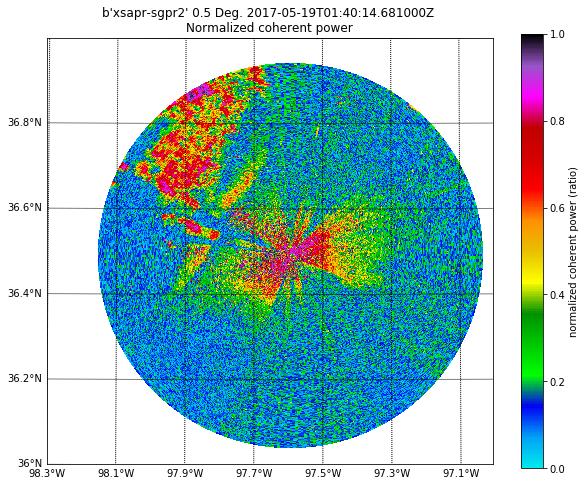

time: 895 ms


In [19]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('normalized_coherent_power', sweep=0,
                     resolution='c', vmin=0, vmax=1,
                     mask_outside=False, cmap=pyart.graph.cm.NWSRef,
                     min_lat=min_lat, min_lon=min_lon,
                     max_lat=max_lat, max_lon=max_lon,
                     lat_lines=lal, lon_lines=lol)
# plt.savefig('')

In [20]:
my_fuzz, cats = processing_code.do_my_fuzz(radar)
print(my_fuzz['notes'])
radar.add_field('gate_id', my_fuzz, 
                replace_existing=True)

print(radar.fields['gate_id']['notes'])
cat_dict = {}
for pair_str in radar.fields['gate_id']['notes'].split(','):
    print(pair_str)
    cat_dict.update(
        {pair_str.split(':')[1]:int(pair_str.split(':')[0])})

sorted_cats = sorted(cat_dict.items(), key=operator.itemgetter(1))

doing
Doing melting
Doing snow
Doing rain
Doing multi_trip
Doing no_scatter
Doing hard constraining  melting
(array([   0,    0,    0, ..., 9199, 9199, 9199]), array([ 0,  1,  2, ..., 26, 27, 28]))
Doing hard constraining  multi_trip
(array([4400, 4400, 4400, ..., 9199, 9199, 9199]), array([480, 481, 482, ..., 498, 499, 500]))
Doing hard constraining  melting
(array([1600, 1600, 1600, ..., 9199, 9199, 9199]), array([476, 477, 478, ..., 498, 499, 500]))
Doing hard constraining  rain
(array([2000, 2000, 2000, ..., 9199, 9199, 9199]), array([426, 427, 428, ..., 321, 322, 323]))
Doing hard constraining  melting
(array([   0,    0,    0, ..., 9199, 9199, 9199]), array([  0,   1,   2, ..., 498, 499, 500]))
1
0:melting,1:snow,2:rain,3:multi_trip,4:no_scatter
0:melting,1:snow,2:rain,3:multi_trip,4:no_scatter
0:melting
1:snow
2:rain
3:multi_trip
4:no_scatter
time: 5.32 s


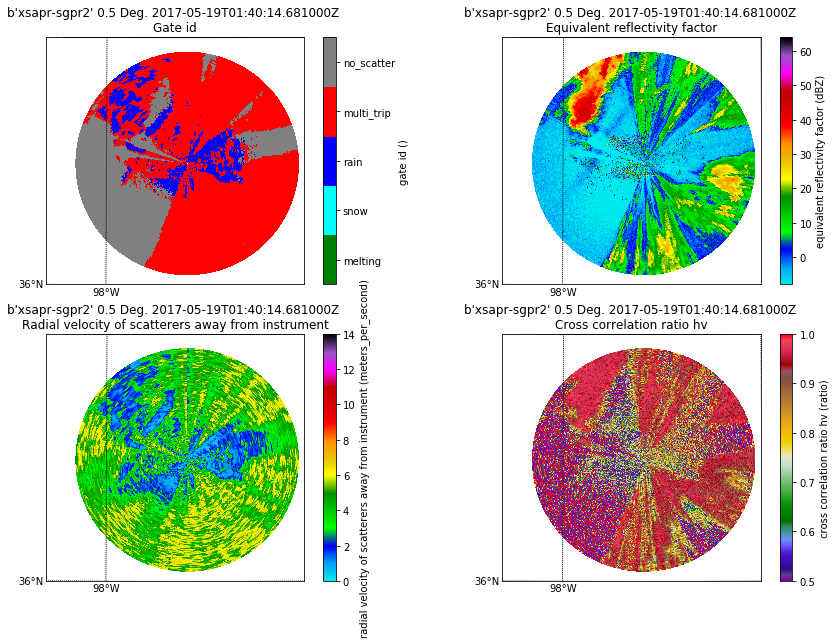

time: 3.76 s


In [21]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lat_lines = np.arange(min_lon, max_lon, .2)

sw = 0

display = pyart.graph.RadarMapDisplay(radar)

f = plt.figure(figsize=[15, 10])
plt.subplot(2, 2, 1) 
lab_colors=['green', 'cyan', 'blue', 'red', 'grey']
cmap = matplotlib.colors.ListedColormap(lab_colors)
display.plot_ppi_map('gate_id', sweep=sw, min_lon=min_lon,
                     max_lon=max_lon, min_lat=min_lat,
                     max_lat=max_lat, resolution='l', cmap=cmap,
                     vmin=0, vmax=5)
cbax=plt.gca()
#labels = [item.get_text() for item in cbax.get_xticklabels()]
#my_display.cbs[-1].ax.set_yticklabels(cats)
tick_locs = np.linspace(0, len(cats) - 1, len(cats)) + 0.5
display.cbs[-1].locator = matplotlib.ticker.FixedLocator(tick_locs)
catty_list = [sorted_cats[i][0] for i in range(len(sorted_cats))]
display.cbs[-1].formatter = matplotlib.ticker.FixedFormatter(catty_list)
display.cbs[-1].update_ticks()
plt.subplot(2, 2, 2) 
display.plot_ppi_map('reflectivity', sweep=sw, vmin=-8, vmax=64,
                     min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                     resolution='l', cmap=pyart.graph.cm.NWSRef)

plt.subplot(2, 2, 3) 
display.plot_ppi_map('velocity_texture', sweep=sw, vmin=0, vmax=14, 
                     min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                     resolution='l', cmap=pyart.graph.cm.NWSRef)
plt.subplot(2, 2, 4) 
display.plot_ppi_map('cross_correlation_ratio', sweep=sw, vmin=.5,
                     vmax=1, min_lon=min_lon, max_lon=max_lon,
                     min_lat=min_lat, max_lat=max_lat, resolution='l',
                     cmap=pyart.graph.cm.Carbone42)

# plt.savefig('')

In [22]:
print(radar.fields['gate_id']['notes'])
cat_dict = {}
for pair_str in radar.fields['gate_id']['notes'].split(','):
    print(pair_str)
    cat_dict.update(
        {pair_str.split(':')[1]:int(pair_str.split(':')[0])})

0:melting,1:snow,2:rain,3:multi_trip,4:no_scatter
0:melting
1:snow
2:rain
3:multi_trip
4:no_scatter
time: 7.37 ms


In [23]:
print(cat_dict)

{'melting': 0, 'snow': 1, 'rain': 2, 'multi_trip': 3, 'no_scatter': 4}
time: 1.78 ms


In [24]:
happy_gates = pyart.correct.GateFilter(radar)
happy_gates.exclude_all()
happy_gates.include_equal('gate_id', cat_dict['rain'])
happy_gates.include_equal('gate_id', cat_dict['melting'])
happy_gates.include_equal('gate_id', cat_dict['snow'])

time: 19.4 ms


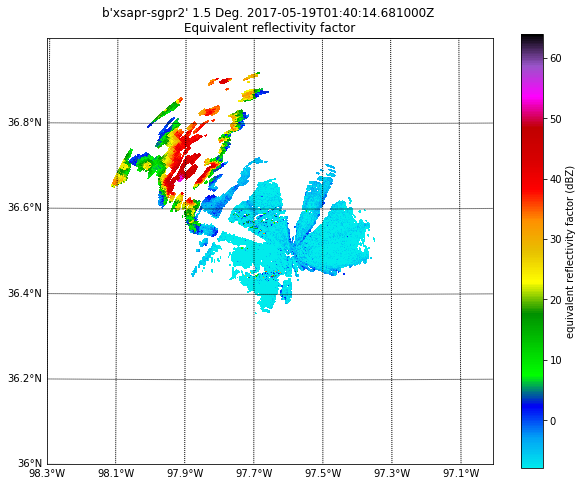

time: 711 ms


In [25]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('reflectivity', sweep=1, resolution='c',
                     vmin=-8, vmax=64, mask_outside=False,
                     cmap=pyart.graph.cm.NWSRef,
                     min_lat=min_lat, min_lon=min_lon,
                     max_lat=max_lat, max_lon=max_lon,
                     lat_lines=lal, lon_lines=lol,
                     gatefilter=happy_gates)
# plt.savefig('')

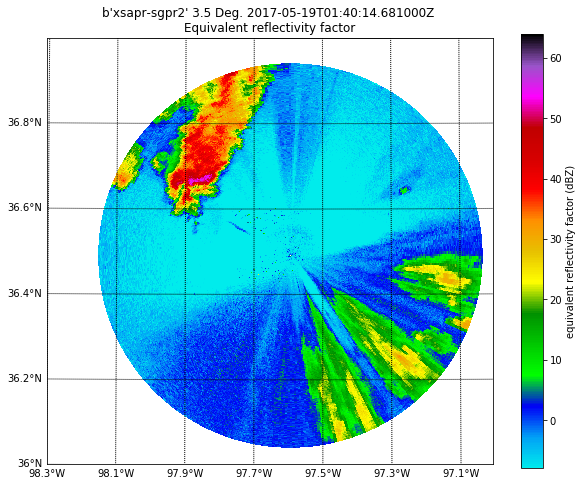

time: 900 ms


In [26]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('reflectivity', sweep=3, resolution='c',
                     vmin=-8, vmax=64, mask_outside=False,
                     cmap=pyart.graph.cm.NWSRef,
                     min_lat=min_lat, min_lon=min_lon,
                     max_lat=max_lat, max_lon=max_lon,
                     lat_lines=lal, lon_lines=lol)
# plt.savefig('')

In [27]:
grids = pyart.map.grid_from_radars(
    (radar, ), grid_shape=(46, 251, 251),
    grid_limits=((0, 15000.0), (-50000, 50000), (-50000, 50000)),
    fields=list(radar.fields.keys()), gridding_algo="map_gates_to_grid",
    weighting_function='BARNES', gatefilters=(happy_gates, ),
    min_radius=200.0)

time: 17.2 s


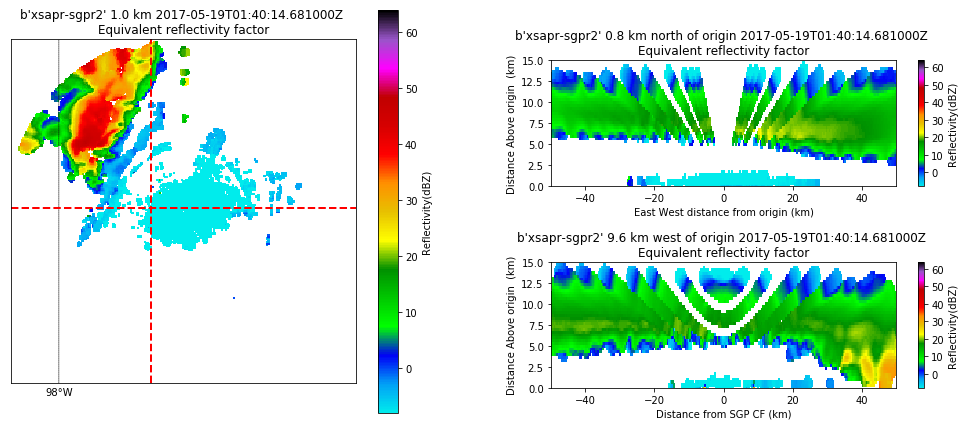

time: 1.35 s


In [28]:
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[15, 7])

# Panel sizes.
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

# Parameters.
level = 3
vmin = -8
vmax = 64
lat = 36.5
lon = -97.7

# Panel 1, basemap, radar reflectivity and NARR overlay.
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = np.arange(-104, -93, 2))
display.plot_grid('reflectivity', level=level, vmin=vmin, vmax=vmax,
                  cmap=pyart.graph.cm.NWSRef)
display.plot_crosshairs(lon=lon, lat=lat)

# Panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                             cmap=pyart.graph.cm.NWSRef)
ax2.set_ylim([0, 15])
ax2.set_xlim([-50, 50])
ax2.set_xlabel('Distance from SGP CF (km)')

# Panel 3, latitude slice.
ax3 = fig.add_axes(y_cut_panel_axes)
ax3.set_ylim([0, 15])
ax3.set_xlim([-50, 50])
display.plot_latitude_slice('reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                            cmap=pyart.graph.cm.NWSRef)
# plt.savefig('')

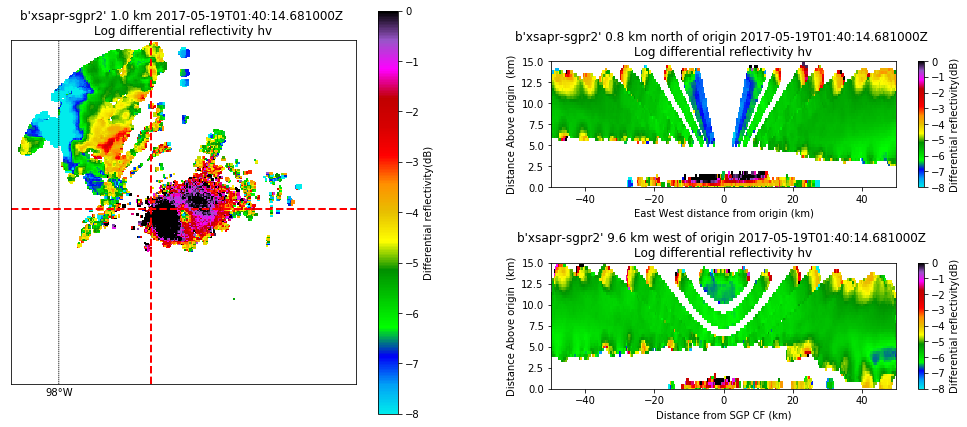

time: 1.04 s


In [29]:
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[15, 7])

# Panel sizes.
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

# Parameters.
level = 3
vmin = -8
vmax = 0
lat = 36.5
lon = -97.7

# Panel 1, basemap, radar reflectivity and NARR overlay.
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = np.arange(-104, -93, 2))
display.plot_grid('differential_reflectivity', level=level, vmin=vmin, vmax=vmax,
                  cmap=pyart.graph.cm.NWSRef)
display.plot_crosshairs(lon=lon, lat=lat)

# Panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('differential_reflectivity', lon=lon, lat=lat, vmin=vmin,
                             vmax=vmax, cmap=pyart.graph.cm.NWSRef)
ax2.set_ylim([0, 15])
ax2.set_xlim([-50, 50])
ax2.set_xlabel('Distance from SGP CF (km)')

# Panel 3, latitude slice.
ax3 = fig.add_axes(y_cut_panel_axes)
ax3.set_ylim([0, 15])
ax3.set_xlim([-50, 50])
display.plot_latitude_slice('differential_reflectivity', lon=lon, lat=lat, vmin=vmin,
                            vmax=vmax, cmap=pyart.graph.cm.NWSRef)
# plt.savefig('')

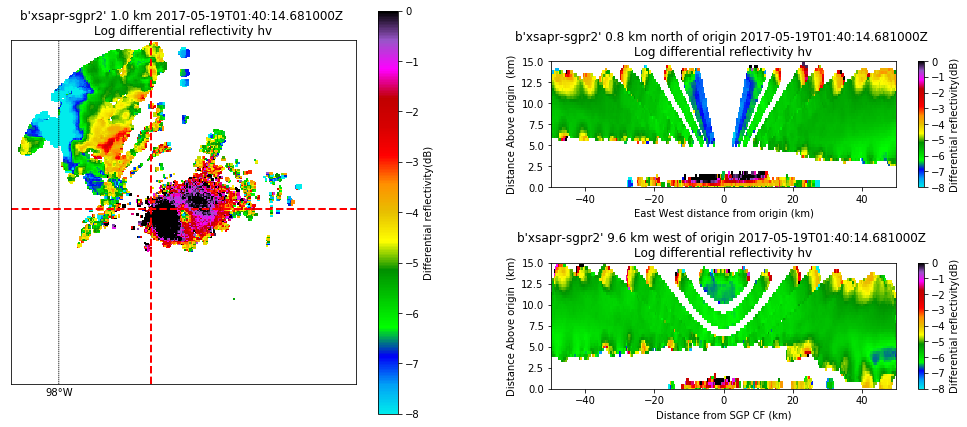

time: 1.08 s


In [30]:
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[15, 7])

# Panel sizes.
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

# Parameters.
level = 3
vmin = -8
vmax = 0
lat = 36.5
lon = -97.7

# Panel 1, basemap, radar reflectivity and NARR overlay.
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = np.arange(-104, -93, 2))
display.plot_grid('differential_reflectivity', level=level, vmin=vmin, vmax=vmax,
                  cmap=pyart.graph.cm.NWSRef)
display.plot_crosshairs(lon=lon, lat=lat)

# Panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('differential_reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                             cmap=pyart.graph.cm.NWSRef)
ax2.set_ylim([0, 15])
ax2.set_xlim([-50, 50])
ax2.set_xlabel('Distance from SGP CF (km)')

# Panel 3, latitude slice.
ax3 = fig.add_axes(y_cut_panel_axes)
ax3.set_ylim([0, 15])
ax3.set_xlim([-50, 50])
display.plot_latitude_slice('differential_reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                            cmap=pyart.graph.cm.NWSRef)

yt : [INFO     ] 2017-06-19 09:01:43,529 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-19 09:01:43,530 Parameters: domain_dimensions         = [251 251  46]
yt : [INFO     ] 2017-06-19 09:01:43,531 Parameters: domain_left_edge          = [-50000. -50000.      0.]
yt : [INFO     ] 2017-06-19 09:01:43,531 Parameters: domain_right_edge         = [ 50000.  50000.  15000.]
yt : [INFO     ] 2017-06-19 09:01:43,534 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-06-19 09:01:43,728 xlim = -50000.000000 50000.000000
yt : [INFO     ] 2017-06-19 09:01:43,729 ylim = -50000.000000 50000.000000
yt : [INFO     ] 2017-06-19 09:01:43,731 xlim = -50000.000000 50000.000000
yt : [INFO     ] 2017-06-19 09:01:43,732 ylim = -50000.000000 50000.000000
yt : [INFO     ] 2017-06-19 09:01:43,734 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [WARNING  ] 2017-06-19 09:01:43,781 Plot image for field ('gas', 'density') has both positive and negative 


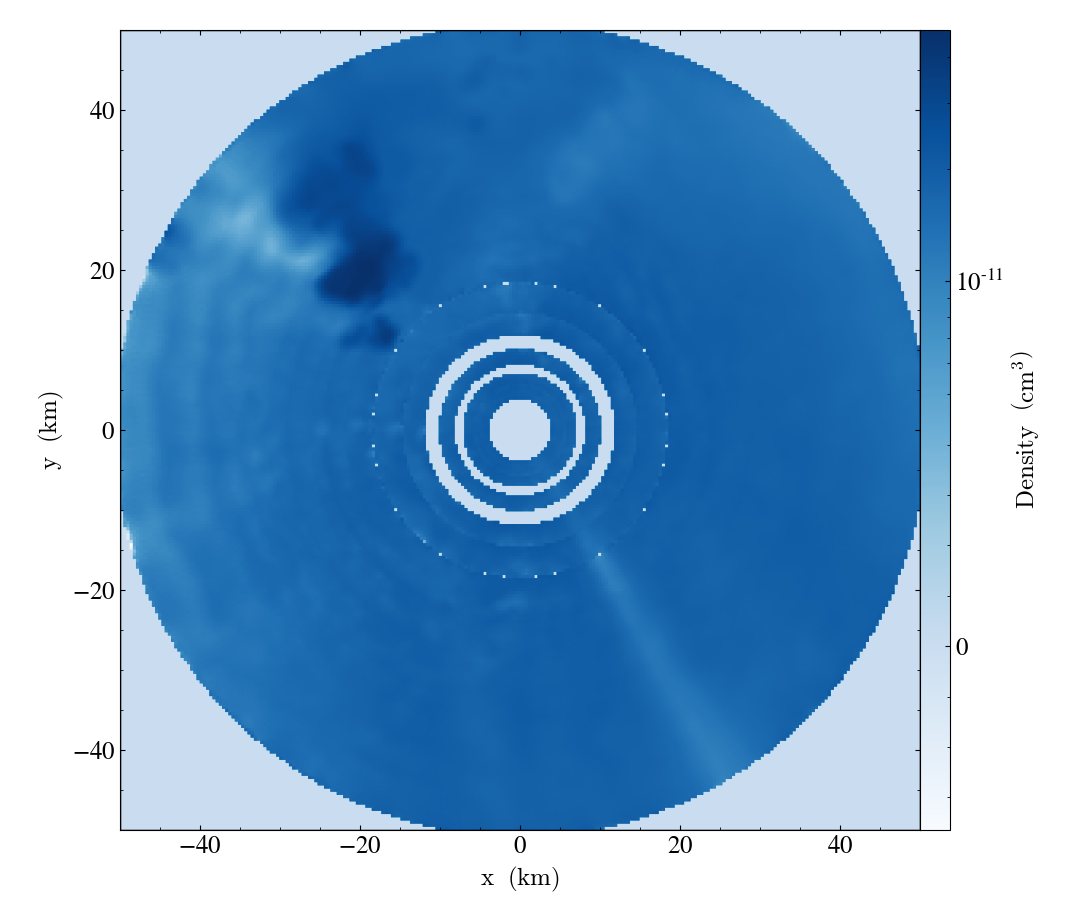

time: 1.07 s


In [31]:
arr = grids.fields['reflectivity']['data']
ff = arr.transpose()
data = dict(density = (ff, "((mm**6)/(m**3))"))
bbox = np.array([[-50000., 50000.], [-50000., 50000.],[0., 15000.0]])
ds = yt.load_uniform_grid(data, ff.shape, length_unit="m", bbox=bbox)

slc = yt.SlicePlot(ds, "z", ["density"])
slc.set_cmap("density", "Blues")
slc.annotate_grids(cmap=None)
slc.show()

yt : [INFO     ] 2017-06-19 09:01:44,598 Setting default field to ('gas', 'density')
yt : [INFO     ] 2017-06-19 09:01:44,610 Creating transfer function
yt : [INFO     ] 2017-06-19 09:01:44,611 Calculating data bounds. This may take a while.  Set the TranferFunctionHelper.bounds to avoid this.
yt : [INFO     ] 2017-06-19 09:01:44,678 Rendering scene (Can take a while).
yt : [INFO     ] 2017-06-19 09:01:44,688 Creating volume


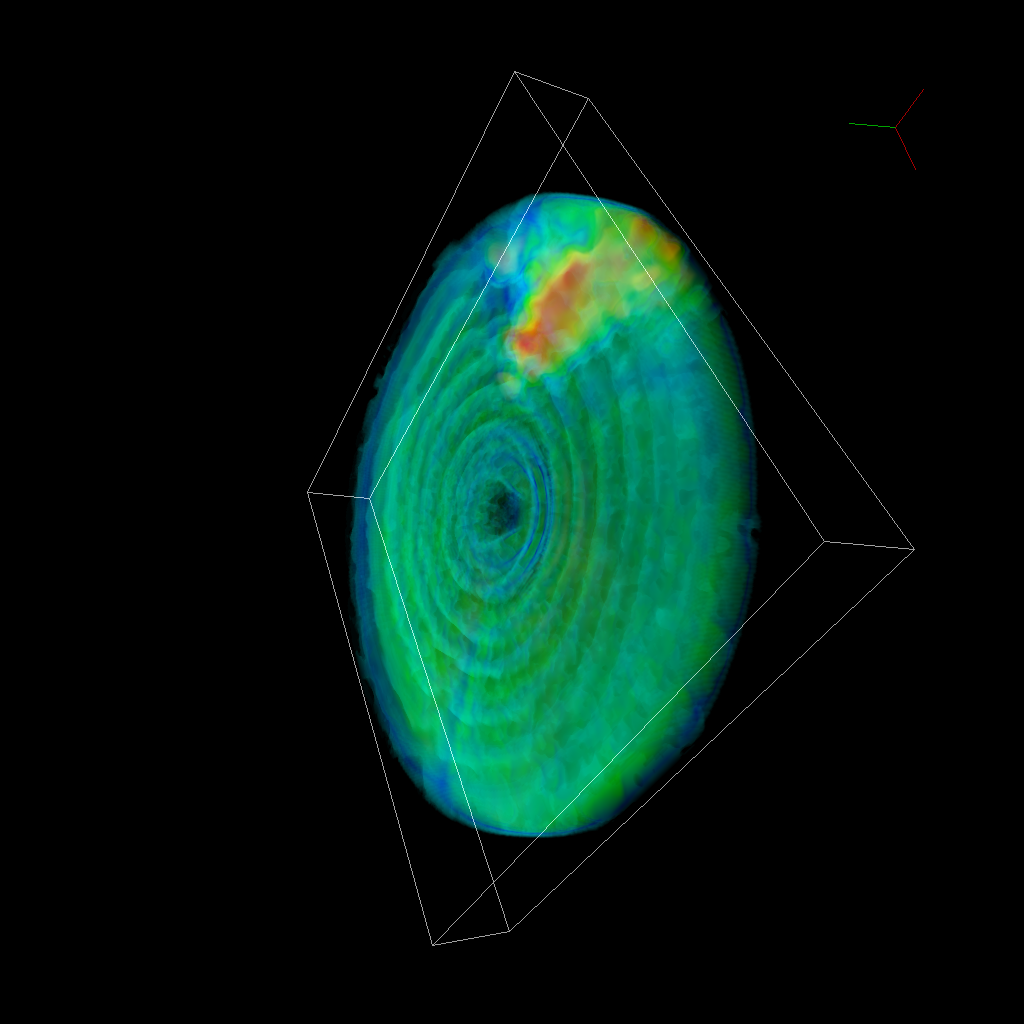

time: 2.99 s


In [32]:
sc = yt.create_scene(ds, lens_type='perspective')

source = sc[0]

source.set_field('density')
source.set_log(False)

# Modify the transfer function
sc.camera.focus = ds.domain_center
sc.camera.resolution = 1024

sc.camera.roll(np.pi)
# Move the camera position to the other side of the dataset.
sc.camera.position = ds.arr([1, 1, 1], 'unitary')

# First get the render source, in this case the entire domain, with field ('gas','density').
render_source = sc.get_source(0)

# Clear the transfer function.
render_source.transfer_function.clear()
# Map a range of density values (in log space) to the Reds_r colormap.
render_source.transfer_function.map_to_colormap(
    ds.quan(-10.0, 'g/cm**3'),
    ds.quan(64., 'g/cm**3'),
    scale=15.0, colormap=pyart.graph.cm.NWSRef)

# Draw the domain boundary.
sc.annotate_axes(alpha=.52)

sc.annotate_domain(ds, color=[1, 1, 1, 0.51])

# sc.save('')
sc.show()

In [33]:
def hello(friend, kwargs_for_person_greet={}, kwargs_for_bdubs={}):
    if friend is 'Tom':
        whom =  person_greet(**kwargs_for_person_greet)
        shorewood = bdubs(**kwargs_for_bdubs)
    return
def person_greet(best_friend=False, not_friend=True):
    if best_friend:
        print('yo homie')
    if not_friend:
        print('piss off')

def bdubs(shorewood=None, plainfield=None):
    if shorewood:
        print(shorewood)
    if plainfield:
        print(plainfield)

time: 14.5 ms


In [34]:
hello('Tom', {best_friend==True}, {shorewood=='In Plainfield'})

NameError: name 'best_friend' is not defined

time: 140 ms


In [35]:
ra = pyart.io.read('/home/zsherman/Downloads/nsakasacrhsrhiC1.a1.20111208.212833.nc')

AttributeError: 'numpy.str_' object has no attribute 'decode'

time: 23.8 ms


In [36]:
import netCDF4

time: 1.74 ms


In [37]:
arr = np.array([[b'r', b'h', b'i', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
                 b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
                 b' ', b' '],
                [b'r', b'h', b'i', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
                 b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
                 b' ', b' '],
                [b'r', b'h', b'i', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
                 b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
                 b' ', b' '],
                [b'r', b'h', b'i', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
                 b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
                 b' ', b' '],
                [b'r', b'h', b'i', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
                 b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
                 b' ', b' '],
                [b'r', b'h', b'i', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
                 b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
                 b' ', b' '],
                [b'r', b'h', b'i', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
                 b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
                 b' ', b' ']], dtype='|S1')

time: 20.1 ms


In [38]:
arr.shape

(7, 24)

time: 5.81 ms


In [39]:
try:
    mode = netCDF4.chartostring(arr[()].decode('utf-8'))
except AttributeError:
    # Python 3, all strings are already unicode.        
    mode = netCDF4.chartostring(arr[0])[()]

time: 3.49 ms


In [40]:
mode

'rhi                     '

time: 1.99 ms


In [41]:
if mode == 'rhi':
    scan_boo = 'rhi'
elif 'rhi' in mode:
    scan_boo = 'rhi'

time: 1.59 ms


In [42]:
scan_boo

'rhi'

time: 2.26 ms


In [43]:
str_array = netCDF4.chartostring(arr, 'utf-8')
str_array

array(['rhi                     ', 'rhi                     ',
       'rhi                     ', 'rhi                     ',
       'rhi                     ', 'rhi                     ',
       'rhi                     '], 
      dtype='<U24')

time: 2.72 ms


In [44]:
assert arr.shape == (7, 24)
assert arr.dtype.char == 'S'
try:
    for i in str_array:
        assert i.strip() == 'rhi'
except AssertionError:
    for i in str_array:
        assert i.strip() == b'rhi'

time: 4.83 ms


In [45]:
try:
    assert np.all(str_array == ['azimuth_surveillance'])
except AssertionError:
    assert np.all(str_array == [b'azimuth_surveillance'])

AssertionError: 

time: 19.1 ms


In [46]:
str_array[0].strip()

'rhi'

time: 2.13 ms


In [47]:
foo = b'rhi         '

time: 1.28 ms


In [48]:
foo.strip()

b'rhi'

time: 1.98 ms


In [58]:
radar = pyart.io.read_cfradial(pyart.testing.CFRADIAL_PPI_FILE)

AttributeError: 'numpy.str_' object has no attribute 'decode'

time: 60.3 ms


In [67]:
import matplotlib.pyplot as plt

time: 2.54 ms


In [64]:
ra_iris = pyart.io.read('/home/zsherman/Downloads/SUR160603110001.RAW1GZR')

/home/zsherman/.local/lib/python3.5/site-packages/pyart/io/sigmet.py:141: RuntimeWarning: invalid value encountered in sqrt
  sigmet_data, sigmet_metadata = sigmetfile.read_data(full_xhdr=full_xhdr)


time: 320 ms


In [66]:
ra_iris.fields.keys()

dict_keys(['specific_differential_phase', 'cross_correlation_ratio', 'normalized_coherent_power', 'spectrum_width', 'reflectivity', 'differential_phase', 'differential_reflectivity', 'velocity', 'total_power', 'radar_echo_classification'])

time: 3.44 ms


In [136]:
ra_iris.fields['radar_echo_classification']['data'].min()

9.0

time: 8.06 ms


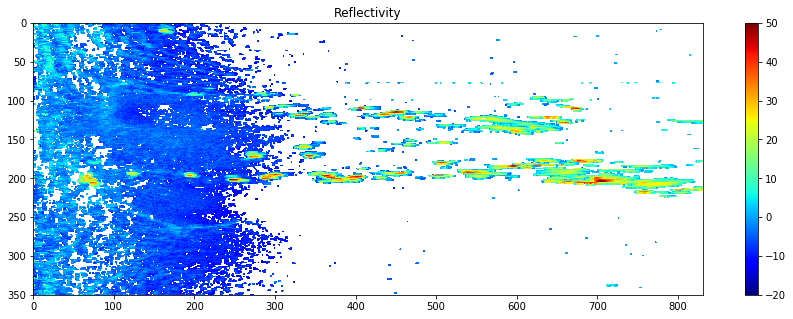

time: 1.34 s


In [137]:
fig = plt.figure(figsize=[15, 5])
plt.title('Reflectivity')
plt.pcolormesh(ra_iris.fields['reflectivity']['data'], cmap='jet', vmax=50, vmin=-20)
plt.ylim(0, 350)
plt.gca().invert_yaxis()
plt.colorbar()

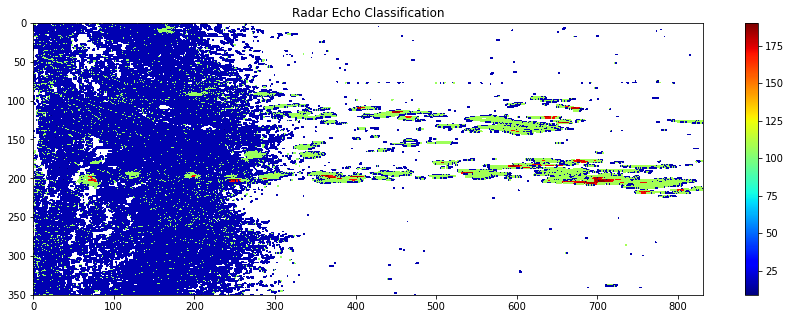

time: 1.1 s


In [134]:
fig = plt.figure(figsize=[15, 5])
plt.title('Radar Echo Classification')
plt.pcolormesh(ra_iris.fields['radar_echo_classification']['data'], cmap='jet')
plt.ylim(0, 350)
plt.gca().invert_yaxis()
plt.colorbar()

In [76]:
ra_iris.scan_type

'ppi'

time: 3.68 ms


In [117]:
display = pyart.graph.RadarMapDisplay(ra_iris)

time: 932 µs


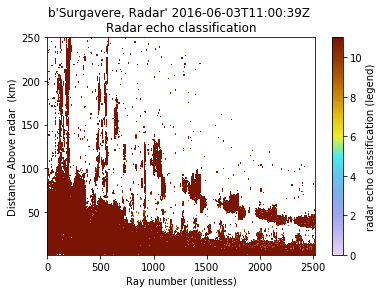

time: 1.47 s


In [118]:
display.plot_vpt('radar_echo_classification')

In [8]:
import pyart
import numpy as np
from numpy.testing import assert_raises, assert_allclose, assert_almost_equal

In [41]:
# test_gate_x_y_z
radar = pyart.testing.make_empty_ppi_radar(5, 4, 2)
radar.azimuth['data'][:] = [0, 90, 180, 270, 0, 90, 180, 270]
radar.elevation['data'][:] = [0, 0, 0, 0, 10, 10, 10, 10]
radar.range['data'][:] = [5, 15, 25, 35, 45]

assert radar.gate_x['data'].shape == (8, 5)
assert_allclose(radar.gate_x['data'][0], [0, 0, 0, 0, 0], atol=1e-14)
assert_allclose(radar.gate_x['data'][1], [5, 15, 25, 35, 45], atol=1e-14)
assert_allclose(radar.gate_x['data'][2], [0, 0, 0, 0, 0], atol=1e-5)
assert_allclose(
    radar.gate_x['data'][3], [-5, -15, -25, -35, -45], atol=1e-14)

assert radar.gate_y['data'].shape == (8, 5)
assert_allclose(radar.gate_y['data'][0], [5, 15, 25, 35, 45], atol=1e-14)
assert_allclose(radar.gate_y['data'][1], [0, 0, 0, 0, 0], atol=1e-5)
assert_allclose(
    radar.gate_y['data'][2], [-5, -15, -25, -35, -45], atol=1e-14)
assert_allclose(radar.gate_y['data'][3], [0, 0, 0, 0, 0], atol=1e-6)

assert radar.gate_z['data'].shape == (8, 5)
z_sweep0 = np.array([1.47e-6, 1.324e-5, 3.679e-5, 7.210e-5, 1.1919e-4])
assert_allclose(radar.gate_z['data'][0], z_sweep0, atol=1e-3)
assert_allclose(radar.gate_z['data'][1], z_sweep0, atol=1e-3)
assert_allclose(radar.gate_z['data'][2], z_sweep0, atol=1e-3)
assert_allclose(radar.gate_z['data'][3], z_sweep0, atol=1e-3)

In [29]:
# test_get_gate_x_y_z
radar = pyart.testing.make_empty_ppi_radar(5, 4, 2)
radar.azimuth['data'][:] = [0, 90, 180, 270, 0, 90, 180, 270]
radar.elevation['data'][:] = [0, 0, 0, 0, 10, 10, 10, 10]
radar.range['data'][:] = [5, 15, 25, 35, 45]

gate_x, gate_y, gate_z = radar.get_gate_x_y_z(0)
assert gate_x.shape == (4, 5)
assert_allclose(gate_x[0], [0, 0, 0, 0, 0], atol=1e-5)
assert_allclose(gate_x[1], [5, 15, 25, 35, 45], atol=1e-14)
assert_allclose(gate_x[2], [0, 0, 0, 0, 0], atol=1e-5)
assert_allclose(gate_x[3], [-5, -15, -25, -35, -45], atol=1e-14)

assert gate_y.shape == (4, 5)
assert_allclose(gate_y[0], [5, 15, 25, 35, 45], atol=1e-14)
assert_allclose(gate_y[1], [0, 0, 0, 0, 0], atol=1e-5)
assert_allclose(gate_y[2], [-5, -15, -25, -35, -45], atol=1e-14)
assert_allclose(gate_y[3], [0, 0, 0, 0, 0], atol=1e-5)

assert gate_z.shape == (4, 5)
z_sweep0 = np.array([1.47e-6, 1.324e-5, 3.679e-5, 7.210e-5, 1.1919e-4])
assert_allclose(gate_z[0], z_sweep0, atol=1e-3)
assert_allclose(gate_z[1], z_sweep0, atol=1e-3)
assert_allclose(gate_z[2], z_sweep0, atol=1e-3)
assert_allclose(gate_z[3], z_sweep0, atol=1e-3)

In [46]:
# test_get_gate_x_y_z_edges
radar = pyart.testing.make_empty_ppi_radar(5, 4, 1)
radar.azimuth['data'][:] = [315., 45, 135., 225.]
radar.elevation['data'][:] = [0, 0, 0, 0]
radar.range['data'][:] = [5, 15, 25, 35, 45]

gate_x, gate_y, gate_z = radar.get_gate_x_y_z(0, edges=True)

zeros = np.array([0, 0, 0, 0, 0, 0])
even = np.array([0, 10, 20, 30, 40, 50])
atol = 1e-4

assert gate_x.shape == (5, 6)
assert_allclose(gate_x[0], -even, atol=atol)
assert_allclose(gate_x[1], zeros, atol=atol)
assert_allclose(gate_x[2], even, atol=atol)
assert_allclose(gate_x[3], zeros, atol=atol)
assert_allclose(gate_x[4], -even, atol=atol)

assert gate_y.shape == (5, 6)
assert_allclose(gate_y[0], zeros, atol=atol)
assert_allclose(gate_y[1], even, atol=atol)
assert_allclose(gate_y[2], zeros, atol=atol)
assert_allclose(gate_y[3], -even, atol=atol)
assert_allclose(gate_y[4], zeros, atol=atol)

assert gate_z.shape == (5, 6)
z_sweep0 = np.array([0, 5.89e-6, 2.354e-5, 5.297e-5, 9.418e-5, 1.4715e-4])
assert_allclose(gate_z[0], z_sweep0, atol=1e-3)
assert_allclose(gate_z[1], z_sweep0, atol=1e-3)
assert_allclose(gate_z[2], z_sweep0, atol=1e-3)
assert_allclose(gate_z[3], z_sweep0, atol=1e-3)
assert_allclose(gate_z[4], z_sweep0, atol=1e-3)

In [53]:
# test_get_gate_x_y_z_transitions
radar = pyart.testing.make_empty_ppi_radar(5, 4, 2)
radar.azimuth['data'][:] = [0, 90, 180, 270, 0, 90, 180, 270]
radar.elevation['data'][:] = [0, 0, 0, 0, 10, 10, 10, 10]
radar.range['data'][:] = [5, 15, 25, 35, 45]
radar.antenna_transition = {'data': np.array([0, 0, 1, 0, 0, 0, 0, 0])}

gate_x, gate_y, gate_z = radar.get_gate_x_y_z(0, filter_transitions=True)
assert gate_x.shape == (3, 5)
assert_allclose(gate_x[0], [0, 0, 0, 0, 0], atol=1e-14)
assert_allclose(gate_x[1], [5, 15, 25, 35, 45], atol=1e-14)
assert_allclose(gate_x[2], [-5, -15, -25, -35, -45], atol=1e-14)

assert gate_y.shape == (3, 5)
assert_allclose(gate_y[0], [5, 15, 25, 35, 45], atol=1e-14)
assert_allclose(gate_y[1], [0, 0, 0, 0, 0], atol=1e-5)
assert_allclose(gate_y[2], [0, 0, 0, 0, 0], atol=1e-5)

assert gate_z.shape == (3, 5)
z_sweep0 = np.array([1.47e-6, 1.324e-5, 3.679e-5, 7.210e-5, 1.1919e-4])
assert_allclose(gate_z[0], z_sweep0, atol=1e-3)
assert_allclose(gate_z[1], z_sweep0, atol=1e-3)
assert_allclose(gate_z[2], z_sweep0, atol=1e-3)

In [62]:
# test_init_gate_x_y_z
radar = pyart.testing.make_empty_ppi_radar(5, 4, 1)
radar.azimuth['data'][:] = [0, 90, 180, 270]
radar.elevation['data'][:] = [0, 0, 0, 0]
radar.range['data'][:] = [5, 15, 25, 35, 45]

# access and check initial gate locations
assert_allclose(radar.gate_x['data'][1], [5, 15, 25, 35, 45], atol=1e-14)
assert_allclose(radar.gate_y['data'][0], [5, 15, 25, 35, 45], atol=1e-14)
z_sweep0 = np.array([1.47e-6, 1.324e-5, 3.679e-5, 7.210e-5, 1.1919e-4])
assert_allclose(radar.gate_z['data'][0], z_sweep0, atol=1e-3)

# change range, gate_x, y, z are not updated
radar.range['data'][:] = [15, 25, 35, 45, 55]
assert_allclose(radar.gate_x['data'][1], [5, 15, 25, 35, 45], atol=1e-14)
assert_allclose(radar.gate_y['data'][0], [5, 15, 25, 35, 45], atol=1e-14)
z_sweep0 = np.array([1.47e-6, 1.324e-5, 3.679e-5, 7.210e-5, 1.1919e-4])
assert_allclose(radar.gate_z['data'][0], z_sweep0, atol=1e-3)

# call init_gate_x_y_z, now the attributes are updated
radar.init_gate_x_y_z()
assert_allclose(radar.gate_x['data'][1], [15, 25, 35, 45, 55], atol=1e-14)
assert_allclose(radar.gate_y['data'][0], [15, 25, 35, 45, 55], atol=1e-14)
z_sweep0 = np.array([1.324e-5, 3.679e-5, 7.210e-5, 1.1919e-4, 1.7805e-4])
assert_allclose(radar.gate_z['data'][0], z_sweep0, atol=1e-3)

In [147]:
gate_x

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  5.00000000e+00,   1.50000000e+01,   2.50000000e+01,
          3.50000000e+01,   4.50000000e+01],
       [  6.12323400e-16,   1.83697020e-15,   3.06161700e-15,
          4.28626380e-15,   5.51091060e-15],
       [ -5.00000000e+00,  -1.50000000e+01,  -2.50000000e+01,
         -3.50000000e+01,  -4.50000000e+01]])

time: 4.67 ms


In [148]:
gate_y

array([[  5.00000000e+00,   1.50000000e+01,   2.50000000e+01,
          3.50000000e+01,   4.50000000e+01],
       [  3.06161700e-16,   9.18485099e-16,   1.53080850e-15,
          2.14313190e-15,   2.75545530e-15],
       [ -5.00000000e+00,  -1.50000000e+01,  -2.50000000e+01,
         -3.50000000e+01,  -4.50000000e+01],
       [ -9.18485099e-16,  -2.75545530e-15,  -4.59242550e-15,
         -6.42939570e-15,  -8.26636589e-15]])

time: 6.55 ms


In [149]:
gate_z

array([[  1.47148967e-06,   1.32434070e-05,   3.67872417e-05,
          7.21048564e-05,   1.19192526e-04],
       [  1.47148967e-06,   1.32434070e-05,   3.67872417e-05,
          7.21048564e-05,   1.19192526e-04],
       [  1.47148967e-06,   1.32434070e-05,   3.67872417e-05,
          7.21048564e-05,   1.19192526e-04],
       [  1.47148967e-06,   1.32434070e-05,   3.67872417e-05,
          7.21048564e-05,   1.19192526e-04]])

time: 2.65 ms


In [152]:
radar.gate_x['data']

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  5.00000000e+00,   1.50000000e+01,   2.50000000e+01,
          3.50000000e+01,   4.50000000e+01],
       [  6.12323400e-16,   1.83697020e-15,   3.06161700e-15,
          4.28626380e-15,   5.51091060e-15],
       [ -5.00000000e+00,  -1.50000000e+01,  -2.50000000e+01,
         -3.50000000e+01,  -4.50000000e+01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  4.92403826e+00,   1.47721118e+01,   2.46201812e+01,
          3.44682467e+01,   4.43163081e+01],
       [  6.03020770e-16,   1.80906194e-15,   3.01510262e-15,
          4.22114280e-15,   5.42718249e-15],
       [ -4.92403826e+00,  -1.47721118e+01,  -2.46201812e+01,
         -3.44682467e+01,  -4.43163081e+01]])

time: 5.5 ms


In [153]:
radar.gate_z['data']

array([[  1.47148967e-06,   1.32434070e-05,   3.67872417e-05,
          7.21048564e-05,   1.19192526e-04],
       [  1.47148967e-06,   1.32434070e-05,   3.67872417e-05,
          7.21048564e-05,   1.19192526e-04],
       [  1.47148967e-06,   1.32434070e-05,   3.67872417e-05,
          7.21048564e-05,   1.19192526e-04],
       [  1.47148967e-06,   1.32434070e-05,   3.67872417e-05,
          7.21048564e-05,   1.19192526e-04],
       [  8.68242316e-01,   2.60473551e+00,   4.34124012e+00,
          6.07775615e+00,   7.81428359e+00],
       [  8.68242316e-01,   2.60473551e+00,   4.34124012e+00,
          6.07775615e+00,   7.81428359e+00],
       [  8.68242316e-01,   2.60473551e+00,   4.34124012e+00,
          6.07775615e+00,   7.81428359e+00],
       [  8.68242316e-01,   2.60473551e+00,   4.34124012e+00,
          6.07775615e+00,   7.81428359e+00]])

time: 6.22 ms


In [157]:
radar.gate_z['data'].dtype

dtype('float64')

time: 2.31 ms


In [154]:
ra = pyart.io.read('/home/zsherman/training_exercises/data/KLOT20130417_235520_V06.gz')

time: 9.14 s


In [156]:
ra.gate_z['data'].dtype

dtype('float64')

time: 7.57 ms
